In [1]:
import numpy as np
from os import environ
from os.path import isfile

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.draw import circle
from skimage import measure

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def find_files_like(datapath, startswith, endswith='.npz'):
    from os import listdir
    
    # look for file in folder `datapath` that starts with `startswith`
    filename = []
    for file in listdir(datapath):
        if file.startswith(startswith) and file.endswith(endswith):
            filename.append(file)
    
    return filename

In [3]:
def calc_shape(img):
    # get components of the centroid
    M = measure.moments(img, 1)
    xm = M[0, 1] / M[0, 0]
    ym = M[1, 0] / M[0, 0]
    
    # size
    size = M[0, 0]
    
    # get centralized moments
    mu = measure.moments_central(img, xm, ym)
    muprime = mu / size
    
    # covariance matrix
    cov = np.array([[muprime[2, 0], muprime[1, 1]], [muprime[1, 1], muprime[0, 2]]])
    
    # eigenvalues and eigenvectors
    w, v = np.linalg.eig(cov)
    
    # orientation
    if muprime[2, 0] != muprime[0, 2]:
        theta = 0.5 * np.arctan2(2 * muprime[1, 1], muprime[2, 0] - muprime[0, 2])
    else:
        raise ValueError("Can't compute `theta` because mu'_20 == mu'_02")
        
    # eccentricity
    ecc = np.sqrt(1.0 - np.min(w) / np.max(w))
    
    return size, theta, ecc, w

In [4]:
img_rand = np.round(np.random.rand(100*100).reshape((100, 100)))
assert calc_shape(img_rand)[0] == np.sum(img_rand)

In [5]:
def find_bitmaps(folder, electrodes=[], amps=[],
                 startswith='VIDFileListNew_',
                 endswith='.xls'):
    """Given a list of electrodes and amplitude values, finds the
       corresponding bitmap files in `folder`
       
       Parameters
       ----------
       folder : str
           Data path
       electrodes : list
           A list of electrodes that should be on.
       amps : list
           A list of amplitude values for the specified electrodes.
       startswith : str
           Find files that start with `startswith`
       endswith : str
           Find files that end with `endswith`
    """
    # Given a list of electrodes and amplitude values, finds the corresponding
    # bitmap files in `folder`
    import pandas as pd
    
    if not folder.endswith('/'):
        folder += '/'
    
    # Open file
    files = find_files_like(folder, startswith, endswith)
    if not files:
        raise ValueError('Could not find file')
    else:
        file = files[0]

    # Parse file
    xl = pd.ExcelFile(folder + file)
    df = xl.parse(xl.sheet_names[0])  # assume Sheet 1
    assert 'electrode' in df.columns
    assert 'amplitude' in df.columns
    
    if electrodes and amps:
        # Find rows with right electrodes and amplitude values
        col_el = '_'.join(electrodes)
        col_amp = '_'.join(amps) + '_'
        rows = df.loc[(df['electrode'] == col_el) & (df['amplitude'] == col_amp)]
    else:
        rows = df
    
    return [folder + bmp_folder + '/' + bmp_file
            for bmp_folder, bmp_file in zip(rows['foldername'], rows['filename'])]

In [6]:
def pixel2deg(px_area, px_shape=[384, 384], deg_shape=[80, 80]):
    num_pixels = np.prod(px_shape)
    num_deg = np.prod(deg_shape)
    return px_area / num_pixels * num_deg

In [7]:
def deg2pixel(deg_area, px_shape=[384, 384], deg_shape=[80, 80]):
    num_pixels = np.prod(px_shape)
    num_deg = np.prod(deg_shape)
    return deg_area / num_deg * num_pixels

In [8]:
assert pixel2deg(384*384) == 80*80
assert deg2pixel(80*80) == 384*384

In [9]:
def num_phosphenes(img):
    contours = measure.find_contours(img, 0.5)
    return len(contours)

In [10]:
img = np.zeros((100, 100), dtype=np.uint8)
assert num_phosphenes(img) == 0
for j in range(5):
    rr, cc = circle(j / 5 * img.shape[0] + 10, j / 5 * img.shape[0] + 10, 5)
    img[rr, cc] = 1
    assert num_phosphenes(img) == j + 1

In [11]:
def parse_bitmap_shape(files):
    img = []
    size = []
    theta = []
    ecc = []
    eigen = []
    for f in files:
        if not isfile(f):
            print('Could not find file "' + f + '"')
            continue

        img.append(rgb2gray(imread(f)))
        s, t, e, w = calc_shape(img[-1])
        size.append(s)
        theta.append(t)
        ecc.append(e)
        eigen.append(w)

    size = np.array(size)
    theta = np.array(theta)
    ecc = np.array(ecc)
    eigen = np.array(eigen)
    
    return img, size, theta, ecc, eigen

In [12]:
def plot_shape(files):
    num_rows = 2
    num_cols = np.ceil((len(files) + 1) / num_rows)
    plt.figure(figsize=(18, 6))
    for i, f in enumerate(files):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img[i], cmap='gray')
        plt.axis('off')
        plt.title(f.split('/')[-1])
    plt.subplot(num_rows, num_cols, len(files) + 1)
    plt.imshow(np.mean(np.array(img), axis=0), cmap='gray')
    plt.axis('off')
    plt.title('Average percept')

In [13]:
datafolder = environ['SECOND_SIGHT_DATA'] + '/shape/TB/20080702'

In [14]:
files = find_bitmaps(datafolder, ['L1'], ['1.25'])
print('Found %d files' % len(files))

Found 5 files


In [16]:
img, size, theta, ecc, eigen = parse_bitmap_shape(files)

In [17]:
print('Size: mu +- std')
(np.mean(size), np.std(size))

Size: mu +- std


(632.20000000000005, 111.28054636817703)

In [18]:
print('Minor axis: mu +- std')
(np.mean(eigen[:, 0]), np.std(eigen[:, 0] / 3))

Minor axis: mu +- std


(27.524888353520602, 1.653972442537782)

In [19]:
print('Major axis: mu +- std')
(np.mean(eigen[:, 1]), np.std(eigen[:, 1] / 3))

Major axis: mu +- std


(139.32016991522639, 12.03497121967702)

In [20]:
print('Minor / major axis: mu +- std')
(np.mean(eigen[:, 0] / eigen[:, 1]), np.std(eigen[:, 0] / eigen[:, 1]))

Minor / major axis: mu +- std


(0.20975465112049241, 0.06437998192050319)

In [21]:
print('Angle (deg): mu +- std')
(np.rad2deg(np.mean(theta)), np.rad2deg(np.std(theta)))

Angle (deg): mu +- std


(-55.334067756878738, 3.1474224962759578)

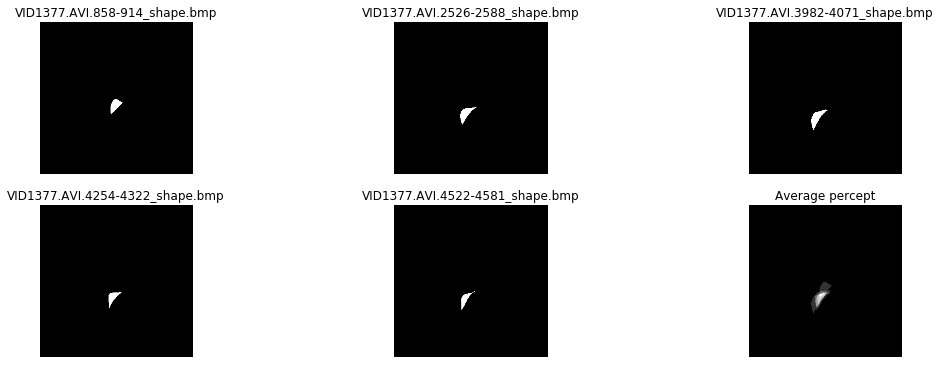

In [22]:
plot_shape(files)